In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numba import njit
import math
import re
import os
from tqdm import tqdm

import scienceplots
plt.style.use(['science', 'no-latex'])

from scipy.optimize import curve_fit

## Автокореллятор

```math
A(\tau) = \frac{\langle E_t E_{t+\tau} \rangle - \langle E_t \rangle^2}
{\langle E_t^2 \rangle - \langle E_t \rangle^2}
```
Скобки $\langle \rangle$ обозначают термодинамическое усреднение по времени. Для нашего случая - по всем доступным нам конфигурациям заданной температуры. Величину $\tau$ и $t$ измеряем в кадрах. Другими словами, это расстояние между кадрами, на котором измеряются корреляции.

Например, у нас есть 100 кадров. При $\tau=0$ среднее берется по всем 100 кадрам. При $\tau=1$, среднее $\langle E_t \rangle$ берется для кадров 0-99, а в $\langle E_t E_{t+\tau} \rangle$ среднее берется так: $(E_0 E_1 + E_1 E_2 + \ldots + E_{98} E_{99})/99$. Для $\tau=2$ аналогично, только $E_0 E_2 + E_1 E_3 + \ldots$.


### Автокоррелятор 2

Не знаю, что там написанно наверху, но напишу тут, как **РЕАЛЬНО** работает автокоррелятор.

Он считает, на сколько отличаются между друг другом пары систем на определённом расстоянии. Таким образом, при $delta=0$ и $N_{sys}=1000$ рассчитается отличие всех 1000 систем с самими собой. Очевидно, получится $A(delta)=1$. 
При $delta=1$ будет рассчитываться изменение систем на расстоянии 1, и, соответственно, будет произведено исследование 999 систем на расстоянии 1 друг от друга. Усредненное значение заносится на график. 
Таким образом, $A(10) = 0.97$ говорит нам о том, что все системы на расстоянии 10 шагов (ну у нас 100 МК шагов, т.к. расстояние между системами 10 МК шагов) в среднем совпадают на 97 процентов.

In [3]:
def load_file(filename):
    sys = np.loadtxt(filename)[:, :-1]
    if (sys == 0).any():
        sys[sys == 0] = np.vectorize(lambda x: -1 if "-" in str(x) else 1)(sys[sys == 0]) 
    sys[:, 2:] /= np.sqrt(sys[:, 2:]**2).sum(axis=1, keepdims=True)
    assert not np.isnan(sys).any(), f"In file {filename} {np.isnan(sys).sum()} nans"
    return sys

def load_file_2(filename):
    with open(filename) as f:
        lines = f.readlines()
        n = len(lines)
        
        # Определяем размер state
        first_line = lines[0]
        state_str = re.findall(r"(?<=state=)\d+", first_line)[0]
        state_size = len(state_str)
        
        # Создаем массивы через empty
        temp = np.empty(n, dtype=int)
        step = np.empty(n, dtype=int)
        state = np.empty((n, state_size), dtype=int)
        
        for i, line in enumerate(tqdm(lines)):
            state_str = re.findall(r"(?<=state=)\d+", line)[0]
            state[i] = np.array([-1 if int(s) else 1 for s in state_str], dtype=int)
            
            temp_vals = re.findall(r"(?<=_)\d+", line)
            temp[i] = int(temp_vals[0])
            step[i] = int(temp_vals[1])
            
    return temp, step, state


temp, step, state = load_file_2("apamea_result_100.txt")
state[temp==0][np.argsort(step[temp == 0])]
s = state[temp == 0][np.argsort(step[temp == 0])]
state

100%|██████████| 500/500 [00:00<00:00, 3084.45it/s]


array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1, -1,  1, ..., -1,  1, -1],
       [ 1,  1,  1, ..., -1, -1, -1],
       [-1, -1, -1, ...,  1,  1,  1]])

In [4]:
temp, step, state = load_file_2("cairo_results.txt")
T_list = np.unique(temp)

100%|██████████| 50000/50000 [00:12<00:00, 4016.60it/s]


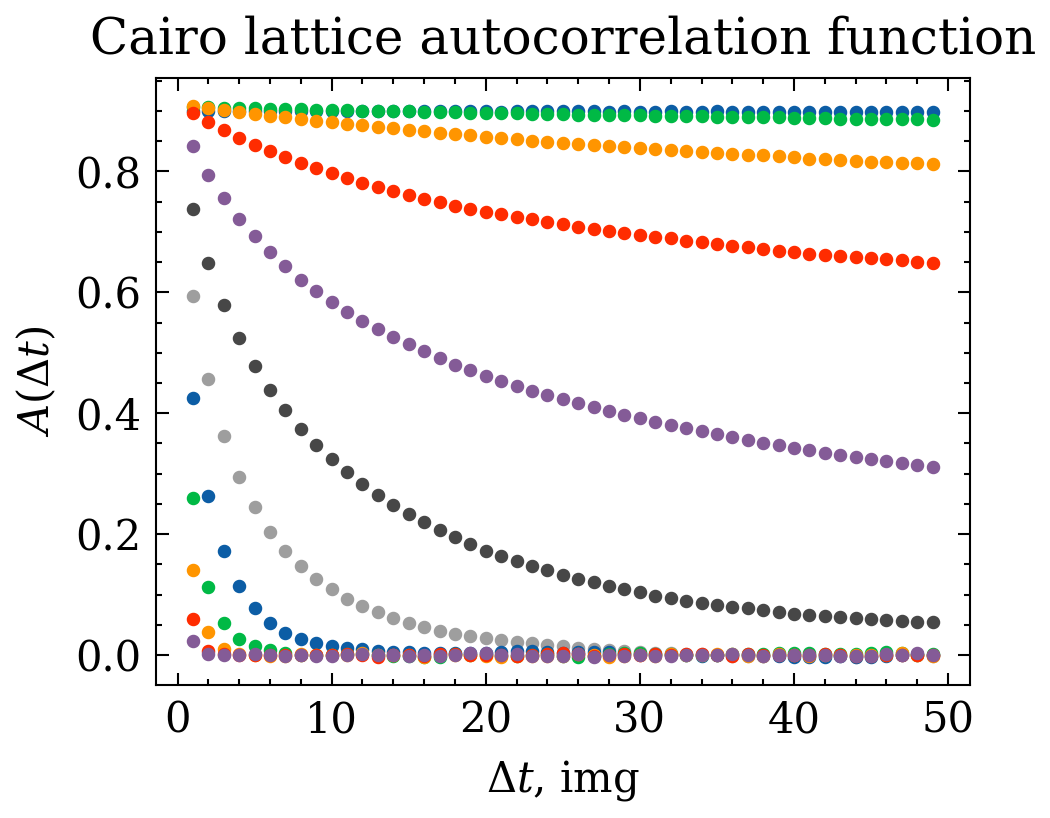

In [6]:
plt.figure(dpi=300)
plt.title(fr'Cairo lattice autocorrelation function')
plt.xlabel(r'$\Delta t$, img')
plt.ylabel(r'$A( \Delta t)$')

colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]

def f(x, t, a, b ):
    return a*np.exp(-x/t) +b
    # return x ** -t


for T in T_list[25:37]:
    spins = state[temp==T][np.argsort(step[temp == T])]
    n = 50
    ydata = np.array([])
    for delta in range(1, n):
        c = np.array([])
        for i in range(1000 - delta):
            c = np.append(c, (spins[i] * spins[i+delta]).mean())
        #print(delta, c.shape)
        #plt.scatter([delta]*len(c), c, s=1)
        #plt.scatter(delta, c.mean(), color=colors[T], s=1, label=f'{T}K' if delta==1 else "")
        ydata = np.append(ydata, c.mean())
    xdata = np.arange(1, n)
    #ydata /= ydata[0]
    plt.scatter(xdata, ydata,  s=5, label=f'{T}K')
    # popt, pcov = curve_fit(f, xdata, ydata, maxfev=10000)
    # plt.plot(xdata, f(xdata, *popt), color='black', linestyle='--', label=f'Fit {T}K: t={popt[0]:.2f}')
    # print(f'Temperature {T}K: t={popt[0]:.2e}, a={popt[1]:.2f}, b={popt[2]:.2f}')
    #plt.savefig(f"3D_ASI_autocorrelation_{T}K.pdf")

# plt.legend()



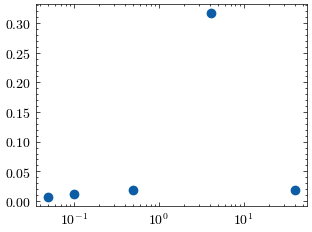

In [20]:
a = np. loadtxt('cairo_N1280.out')
plt.xscale('log')
plt.scatter(a[:,0], a[:,1])

# Замечание

Важное замечание при расчёте этих критических экспонент в том, что в зависимости от разных параметров p0 при подгоне получатся разные параметры t

Причем значительно - на соседних температурах t погут бытьлибо одинакоые, либо с разницей в 5 порядков 

In [ ]:
def load_g(T):
    sys_list = []
    directory = f'145nm_{T}K/'
    n = len(os.listdir(directory))
    for file in os.listdir(directory):
        sys = load_file(directory+file)
        sys_list.append(sys)

    lens = np.vectorize(lambda x: len(x))(sys_list)
    base_sys = sys_list[np.where(lens == np.min(lens))[0][0]]
    spins = np.zeros((len(base_sys), len(sys_list)))
    for i, part in enumerate(base_sys):
        for j, sys in enumerate(sys_list):
            wh = np.where(np.abs(((part[:2] - sys[:, :2])**2).sum(axis=1)) < 8)[0]
            if len(wh) != 0:
                assert len(wh) == 1
                index = wh[0]
                if np.dot(sys[index, 2:], np.array([1, 0])) > 0:
                    spins[i, j] = 1
                elif np.dot(sys[index, 2:], np.array([1, 0])) < 0:
                    spins[i, j] = -1
    for i in range(len(sys_list)-1):
        c = (spins[:, 0]*spins[:, i]).mean()
        if c < 0:
            spins[:, i] *= -1

    return spins

c:\Users\Faikert\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
c:\Users\Faikert\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
c:\Users\Faikert\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays w

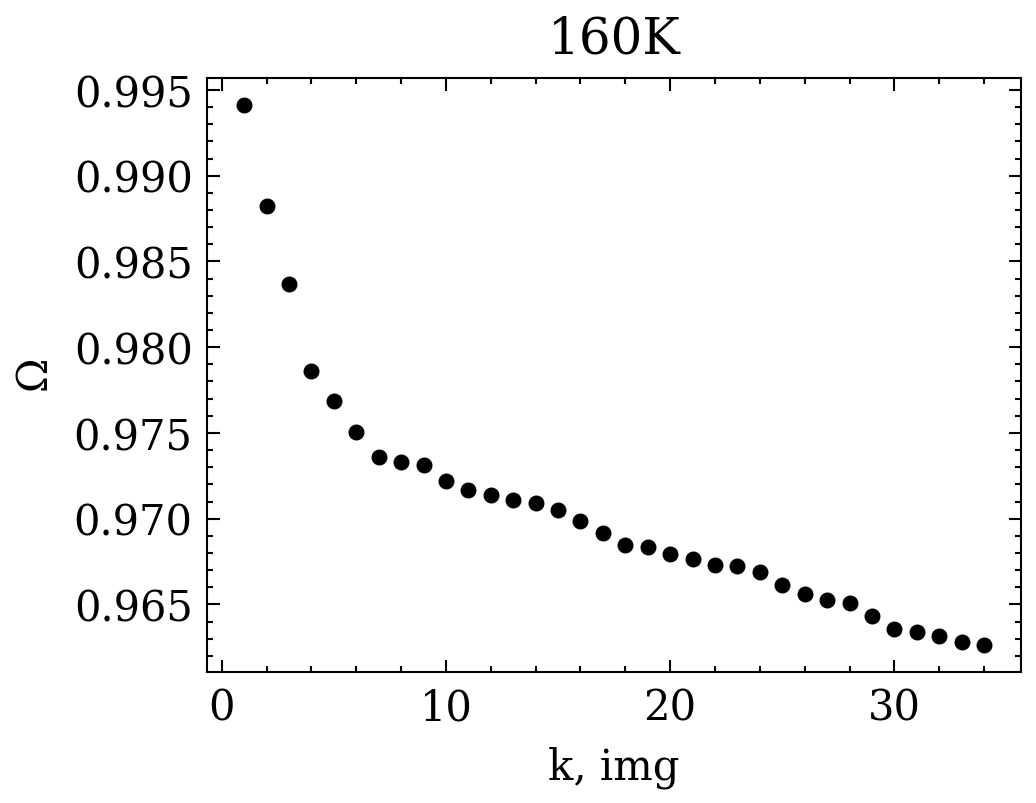

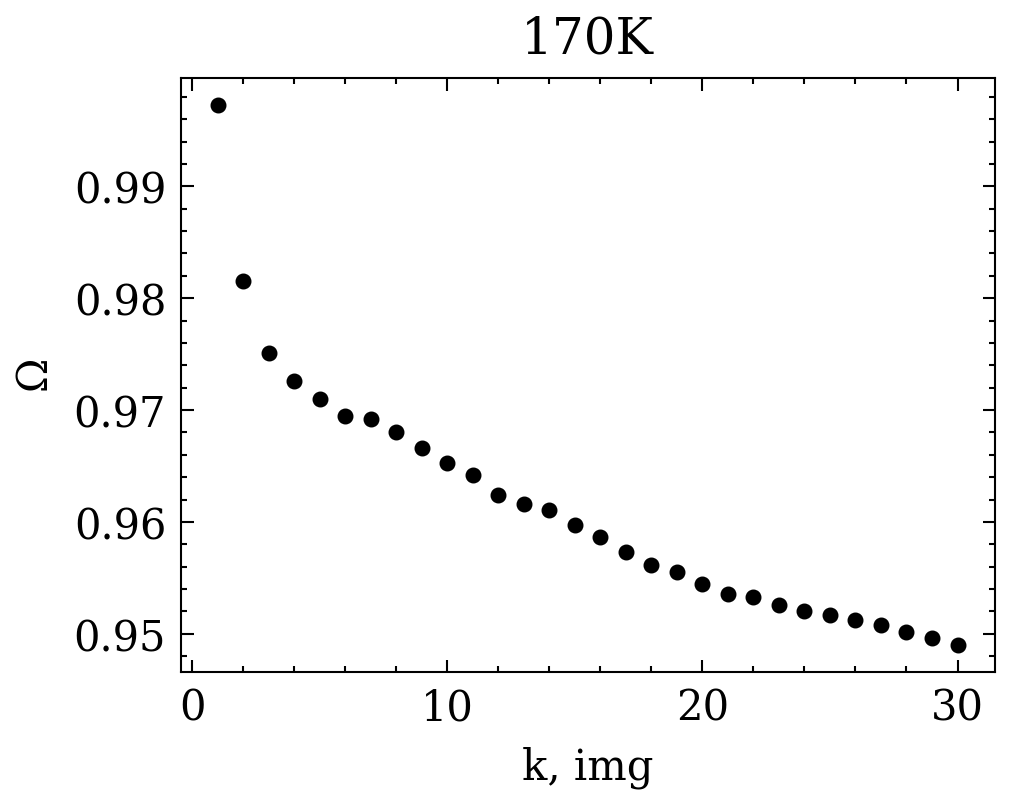

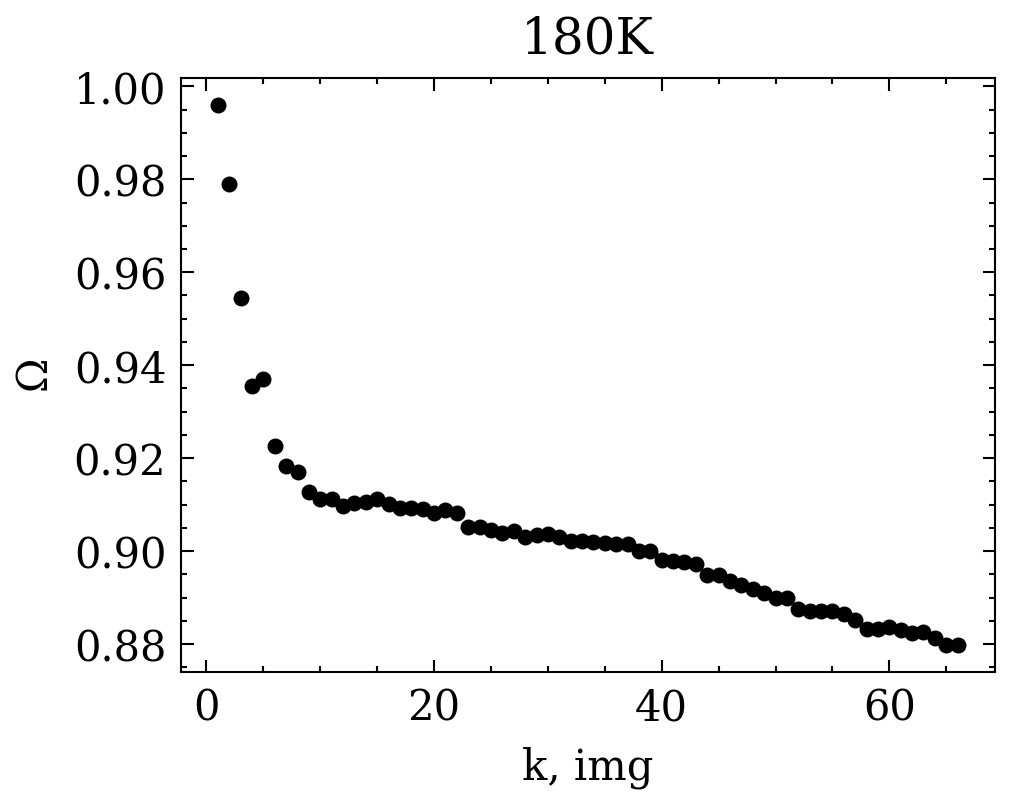

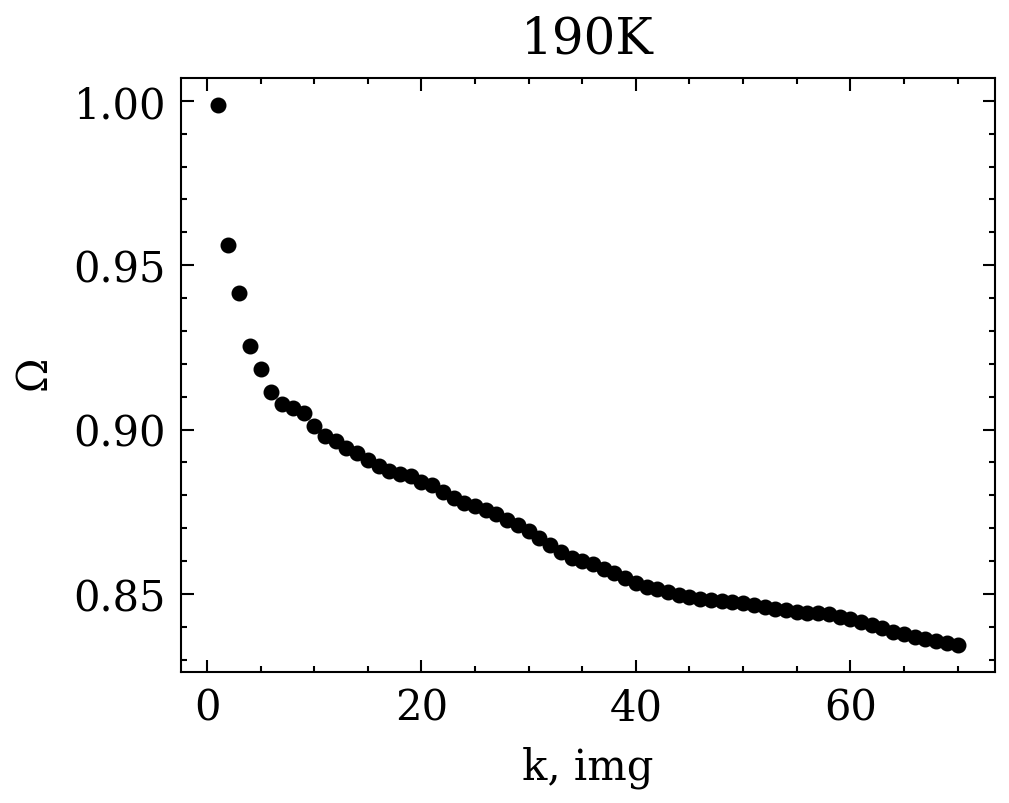

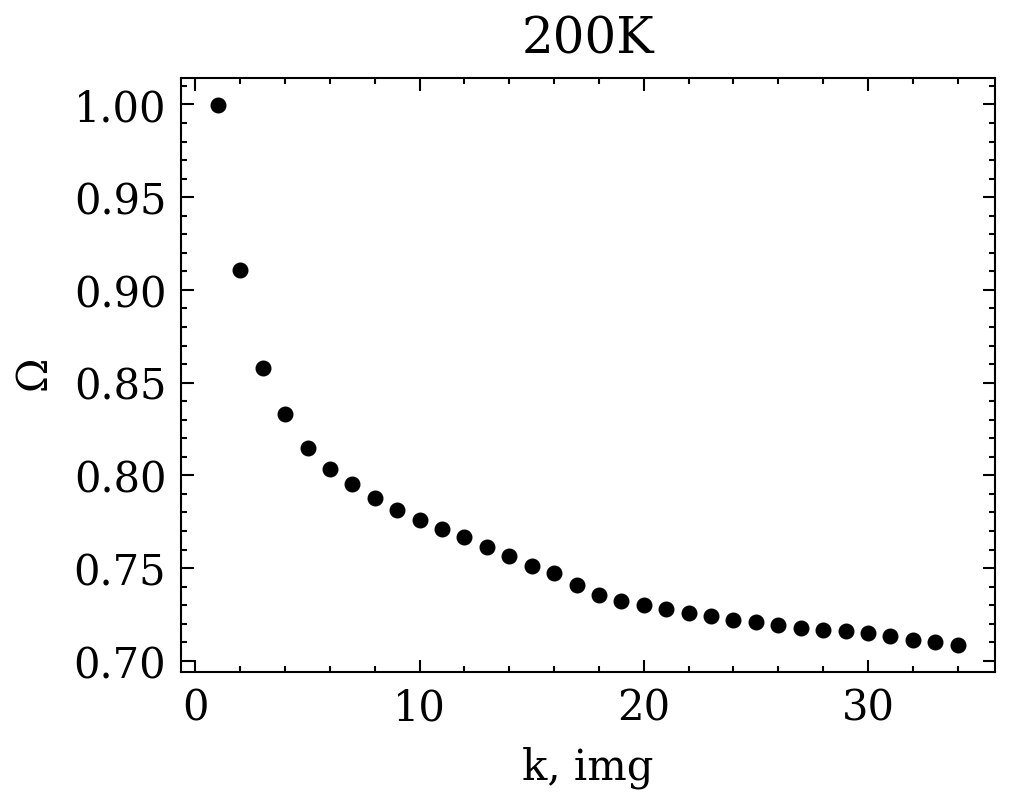

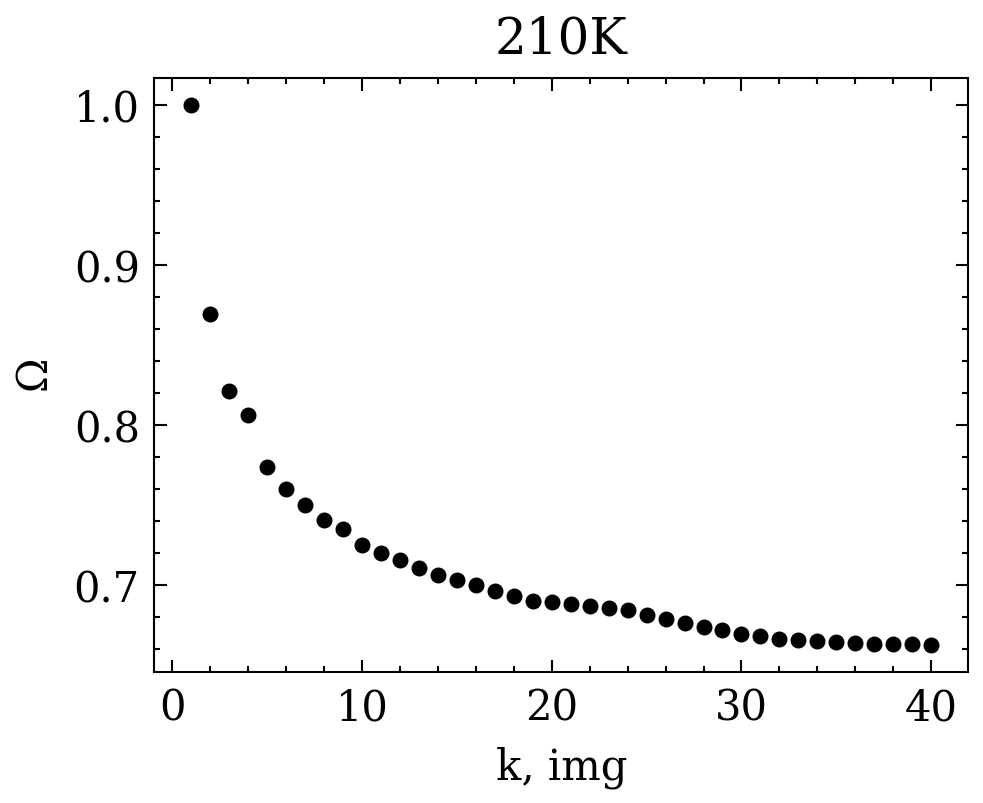

In [ ]:
for i, T in enumerate(T_list):
    arr = []
    spins = load_g(T)
    # Первые три картинки пропускаем, они говно
    if T == 180:
        spins = spins[:, 2:]
    plt.figure(dpi=300)
    plt.title(rf'{T}K')
    for k in range(1, spins.shape[1]+1):
        g = spins[:, :k].mean(axis=1)
        g_mean = g.mean()
        #plt.yscale('log')
        plt.xlabel(r'k, img')
        plt.ylabel(r'$\Omega$')

        gamma_t = ((g - g_mean)**2).mean()
        arr.append(gamma_t)
        plt.scatter(k, gamma_t, s=8, c='black')
    plt.savefig(f"3D_ASI_MT_{T}K.pdf")